# Introducción

Bienvenidos a este ejemplo mínimo sobre cómo realizar un análisis de datos.

Este es un ejemplo mínimo sobre cómo:
1. crear una base de datos y subirla
2. conectarse a una base de datos
3. realizar un análisis de datos
4. subir el análisis a Github y compartirlo con tu equipo.

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlite3

sns.set_theme()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Creando una base de datos

In [4]:
base_path = "/content/drive/My Drive/TripleTen/Projects/Mini Onboarding/"

purchases = pd.read_csv(base_path + "purchases_df.csv")
customers = pd.read_csv(base_path + "customers_df.csv")
items = pd.read_csv(base_path + "items_df.csv")

In [12]:
conn  = sqlite3.connect('database_example')
c = conn.cursor()

c.execute('''
          CREATE TABLE IF NOT EXISTS purchases (
            [customer_id] INTEGER,
            [date] TIMESTAMP,
            [purchases] DOUBLE PRECISION,
            [purchased_item] text
          )
          ''')

c.execute('''
          CREATE TABLE IF NOT EXISTS customers (
            [customer_id] INTEGER PRIMARY KEY,
            [age] INTEGER,
            [gender] TEXT,
            [country] TEXT
          )
          ''')

c.execute('''
          CREATE TABLE IF NOT EXISTS items (
            [item_category] TEXT,
            [item] TEXT
          )
          ''')

conn.commit()

In [14]:
purchases.to_sql(
    name="purchases",
    con=conn,
    if_exists="append",
    index=False,
    chunksize=1_000,
    method="multi"
)

customers.to_sql(
    name="customers",
    con=conn,
    if_exists="append",
    index=False,
    chunksize=1_000,
    method="multi"
)

items.to_sql(
    name="items",
    con=conn,
    if_exists="append",
    index=False,
    chunksize=1_000,
    method="multi"
)

9

In [21]:
query = """
SELECT item_category, item
FROM items
"""

conn_query = conn.execute(query).fetchall()
items_db = pd.DataFrame(conn_query, columns=["item_category", "item"])

In [23]:
items_db.head(2)

,item_category,item
0,kitchen,stove
1,kitchen,microwave


# Conectarse a una base de datos (y realizar una consulta)

Generalmente para acceder a una base de datos (que vive en la nube) se necesitan la siguiente información:

- host
- port
- database name
- database user
- password

Por ahora, como estamos usando una base de datos local, no necesitamos realizar esta conexión y podemos lanzar las consultas a la base de datos directamente.

# Ejemplo mínimo sobre un análisis de datos

Contestaremos algunas preguntas sencillas sobre los datos que tenemos disponibles. Específicamente nos interesa:
- Visualizar la tendencia de ventas por categoría de producto.
- Visualizar la tendencia de ventas por país.

In [42]:
query = """
SELECT
    p.date,
    c.country,
    SUM(p.purchases) AS total_purchases
FROM purchases p
LEFT JOIN customers c
    ON c.customer_id = p.customer_id
GROUP BY p.date, c.country
"""

conn_query = conn.execute(query).fetchall()
daily_trends_by_country = pd.DataFrame(conn_query, columns=["date", "country", "total_purchases"])

In [43]:
daily_trends_by_country["week"] = pd.to_datetime(daily_trends_by_country["date"]).dt.to_period("W").dt.start_time

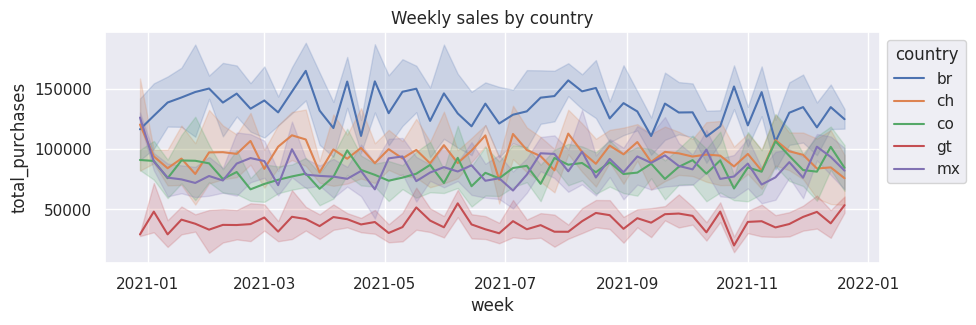

In [45]:
plt.figure(figsize=(10, 3))
sns.lineplot(data=daily_trends_by_country, x="week", y="total_purchases", hue="country", ax=plt.gca())
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))
plt.title("Weekly sales by country")
plt.show()

Notamos lo siguiente:
- El país donde más ventas tenemos es Brasil. Las ventas en Brasil presentan una ligera tenedencia a la baja a partir de 2021-09.
- Tenemos ventas muy similares en Chile, Colombia y México.
- Guatemala es el país donde menos ventas tenemos.

Ideas para futuros análisis
- Comparar las ventas vs. los gastos en marketing que hacemos en cada país para contestar a si es redituable invertir en cada país.
- Estandarizar los datos al tamaño de la población para entender la penetración de nuestros productos en la región.

In [30]:
query = """
SELECT
    p.date,
    i.item_category,
    SUM(p.purchases) AS total_purchases
FROM purchases p
LEFT JOIN items i
    ON i.item = p.purchased_item
GROUP BY p.date, i.item_category
"""

conn_query = conn.execute(query).fetchall()
daily_trends = pd.DataFrame(conn_query, columns=["date", "item_category", "total_purchases"])

In [33]:
daily_trends["week"] = pd.to_datetime(daily_trends["date"]).dt.to_period("W").dt.start_time

In [34]:
daily_trends.head()

,date,item_category,total_purchases,week
0,2021-01-02,bathroom,81958.31,2020-12-28
1,2021-01-02,bedroom,152697.00,2020-12-28
2,2021-01-02,cleaning,204682.89,2020-12-28
3,2021-01-02,kitchen,43088.00,2020-12-28
4,2021-01-03,bathroom,30164.07,2020-12-28


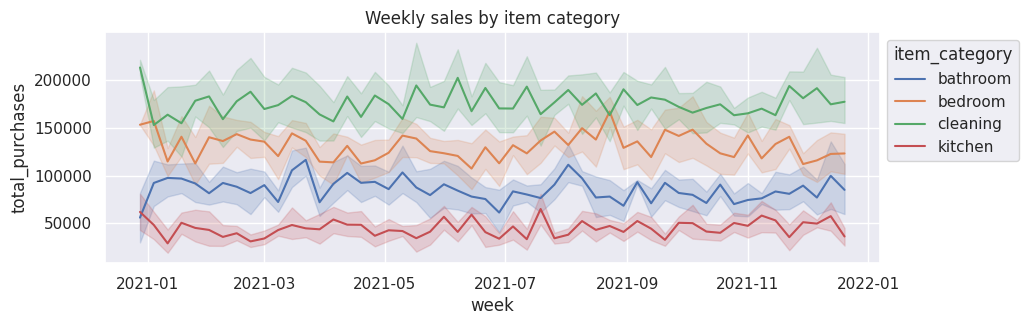

In [46]:
plt.figure(figsize=(10, 3))
sns.lineplot(data=daily_trends, x="week", y="total_purchases", hue="item_category", ax=plt.gca())
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))
plt.title("Weekly sales by item category")
plt.show()

Notamos lo siguiente:
- Las ventas por categoría no presentan una clara tendencia a través del tiempo.
- Observamos una clara separación en las categorías, siendo "cleaning" nuetra categoría más popular y "kitchen" la menos popular.